In [46]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
import os
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import RF_regressor, plot_importances, encode_tulabel
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.utils.directories import get_parent_directory

In [47]:
parent_dir = get_parent_directory()
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/2706_time.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

## Final model


with MLD

In [48]:
# Features:
# xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['sea_ice_concentration','latitude','depth','hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist = ['log_eps']
pipeline, y_test, X_test, importances, X_train, y_train = RF_regressor(arctic_df, xstringlist_all, ystringlist)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
# Predict the test set labels
y_pred = pipeline.predict(X_test)
r2_score(y_test, y_pred)

0.9872076352995516

In [13]:
from pickle import dump, load

filename = os.path.join(parent_dir, "models/RandomForest/SIC_RFMLD.sav")
dump([pipeline, X_train, X_test, y_train, y_test], open(filename, 'wb'))

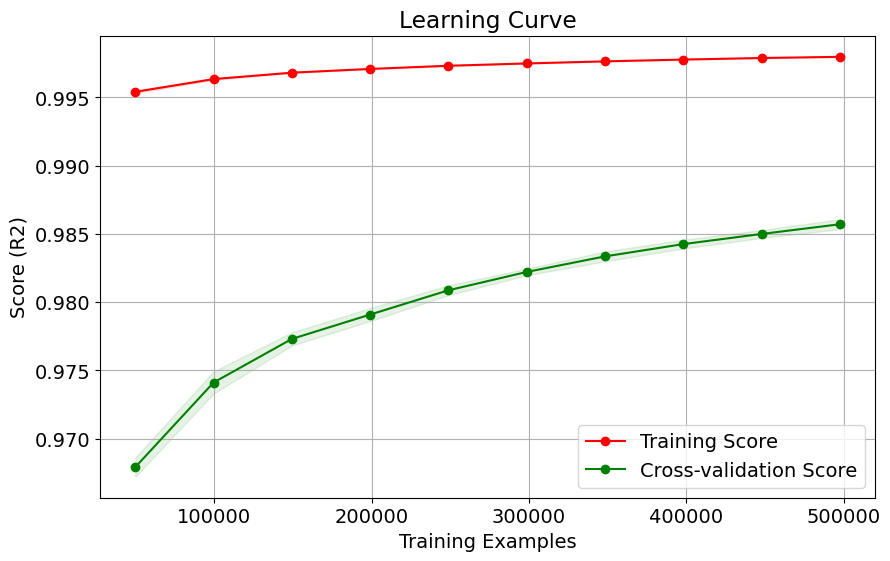

In [12]:
from sklearn.model_selection import learning_curve

# Define the XGBoost regressor model (xgb_regressor_all_SIC) and your data (X_train_SIC, y_train_SIC)
model = pipeline

# Create the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score (R2)")
plt.grid()

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation Score")

plt.legend(loc="best")
plt.show()

In [ ]:
fig = plt.figure(figsize=[22, 10])
ax_imp = fig.add_subplot(1, 1, 1)

plot_importances(xstringlist_all, importances, ax=ax_imp)
plt.show()

exl MLD

In [65]:
# Features:
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]

In [3]:
# Features:
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]
# xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['sea_ice_concentration','latitude','depth','hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist = ['log_eps']
pipelineMLD, y_testMLD, X_testMLD, importancesMLD, X_trainMLD, y_trainMLD = RF_regressor(MLD_df, xstringlist_all, ystringlist)

R2 Score: 0.9886, 95% CI: [0.9882, 0.9890]
Mean Error (ME): -0.0011, 95% CI: [-0.0031, 0.0009]
Mean Absolute Error (MAE): 0.2311, 95% CI: [0.2294, 0.2327]
Residual Standard Deviation: 0.4004, 95% CI: [0.3942, 0.4066]


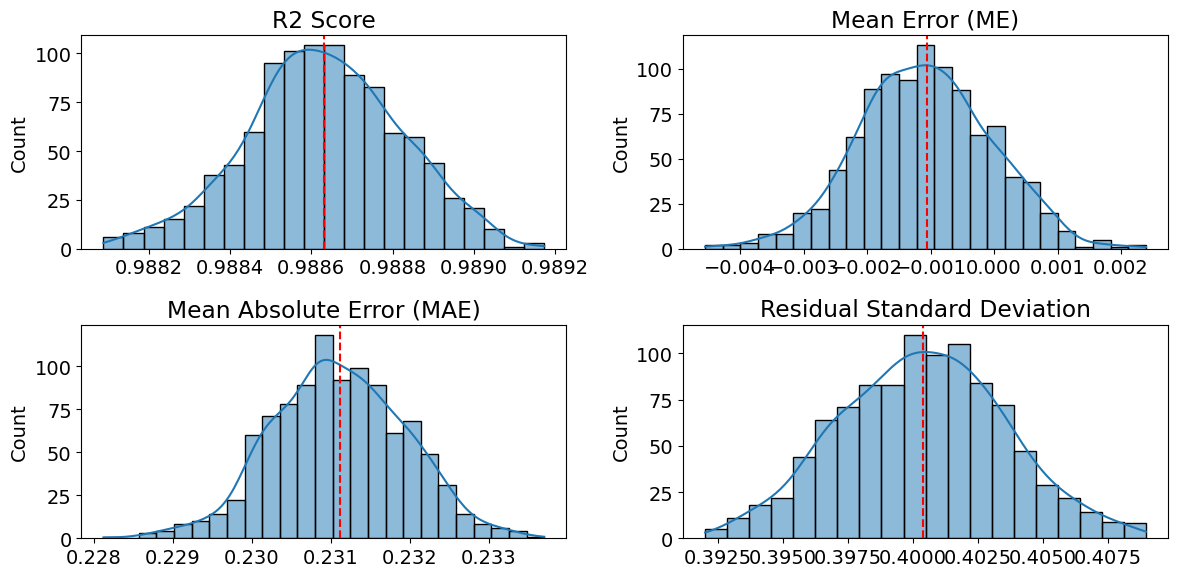

In [7]:
# Predict the test set labels
from src.models.corr_func import confidence_metrics
y_predMLD = pipelineMLD.predict(X_testMLD)
r2_score(y_testMLD, y_predMLD)

confidence_metrics(y_testMLD, y_predMLD)

In [ ]:
from pickle import dump, load

filename = os.path.join(parent_dir, "models/RandomForest/SIC_RF.sav")
dump([pipeline, X_train, X_test, y_train, y_test], open(filename, 'wb'))

In [ ]:
import joblib

In [ ]:
# Save the parameters
joblib.dump(pipelineMLD, 'RandomForest/best_model.sav')
# joblib.dump(r2_tune, 'XGboost/r2_tune.sav')
joblib.dump(y_testMLD, 'RandomForest/y_test_MLDsav')
joblib.dump(y_predMLD, 'RandomForest/y_pred_MLD.sav')
joblib.dump(X_testMLD, 'RandomForest/X_test_MLD.sav')
# joblib.dump(feature_importances_tune, 'XGboost/feature_importances_tune.sav')

In [14]:
y_test = pd.DataFrame(y_test, columns=["log_eps"])

In [16]:
y_pred = pd.DataFrame(y_pred, columns=["log_eps"])

Text(0.5, 1.0, 'Predictions from RandomForestClassifier')

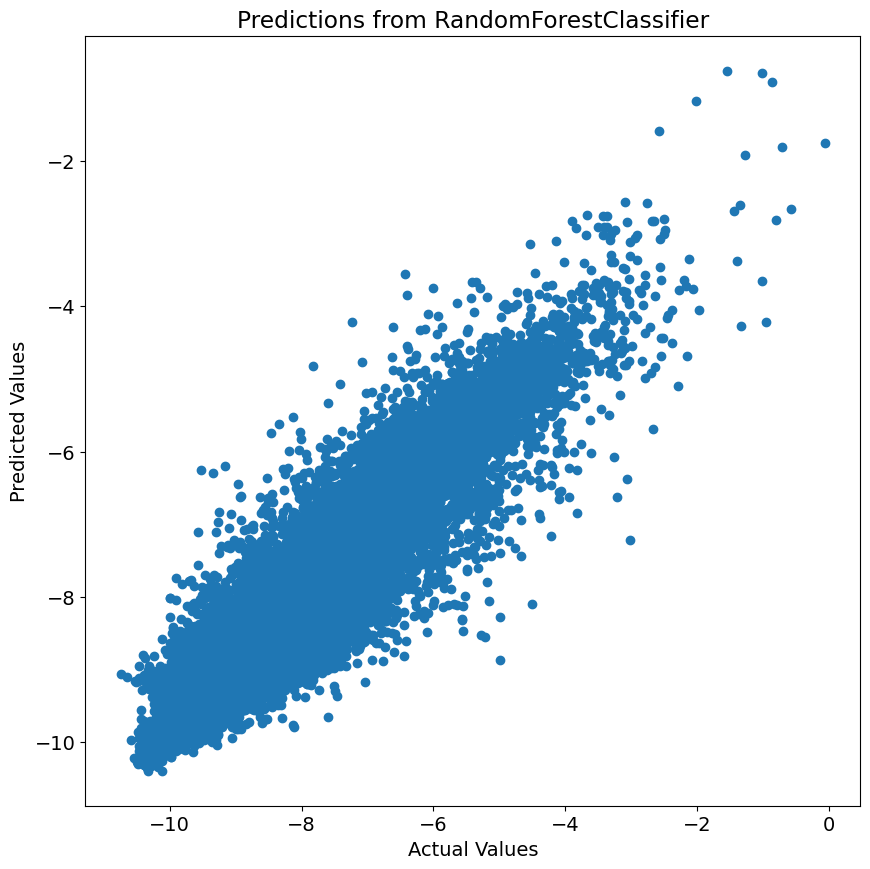

In [22]:
plt.scatter(y_test, y_pred)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions from RandomForestClassifier')

Text(0.5, 1.0, 'Density Plot of Residuals')

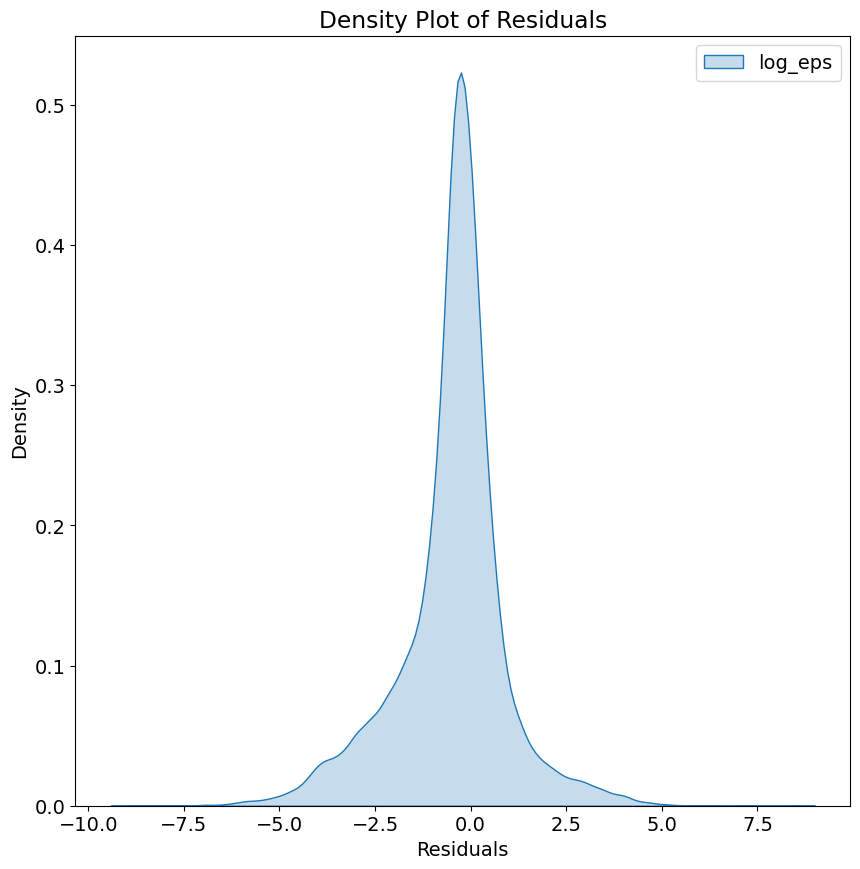

In [25]:
import seaborn as sns

residuals = y_pred - y_test
sns.kdeplot(data=residuals, shade=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Density Plot of Residuals')

## Vary train test split

In [10]:
# Features:
# xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['sea_ice_concentration','latitude','depth','hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist = ['log_eps']

pipeline, y_test, X_test, importances, X_train, y_train = RF_regressor(MLD_df, xstringlist_all, ystringlist, "IPY Barneo 2008")

R2 Score: 0.1324, 95% CI: [0.0979, 0.1650]
Mean Error (ME): 0.0742, 95% CI: [0.0713, 0.0770]
Mean Absolute Error (MAE): 0.2211, 95% CI: [0.2188, 0.2234]
Residual Standard Deviation: 0.3393, 95% CI: [0.3349, 0.3437]


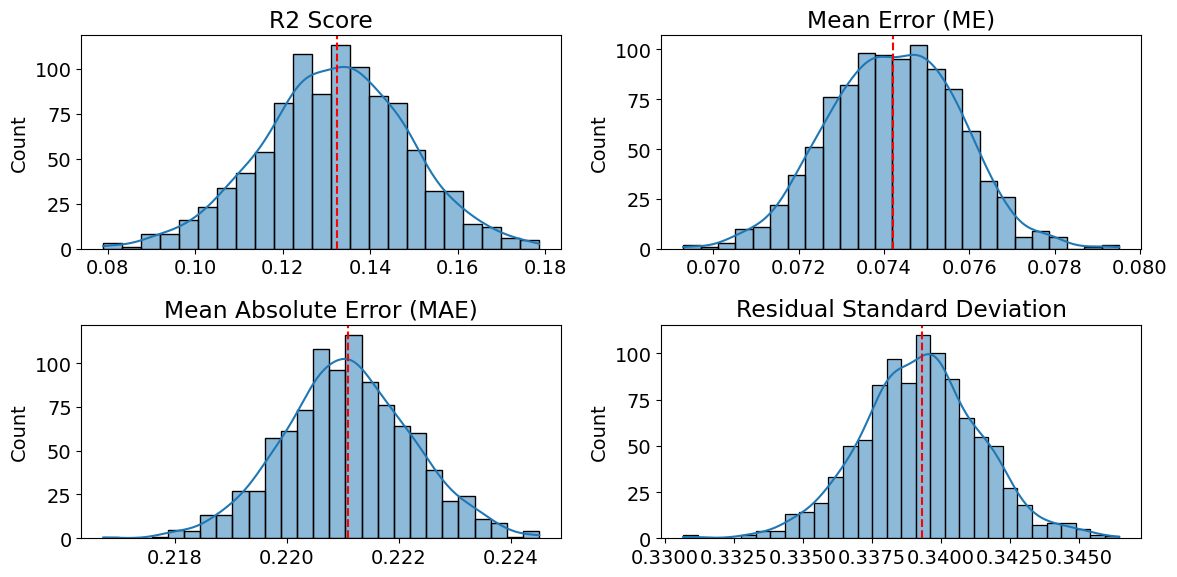

In [11]:
# Predict the test set labels
from src.models.corr_func import confidence_metrics
y_pred= pipeline.predict(X_test)
r2_score(y_test, y_pred)

confidence_metrics(y_test, y_pred)

In [57]:
MLD_df, labels = encode_tulabel(MLD_df)
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test, columns=xstringlist_all)
y_test_df_SIC = pd.DataFrame(y_test, columns=ystringlist)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/RandomForest/Barneo2008_testdf.pkl")
# Pickle the DataFrame
SIC_all_testdf .to_pickle(pickle_path)

merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=xstringlist_all+ystringlist)

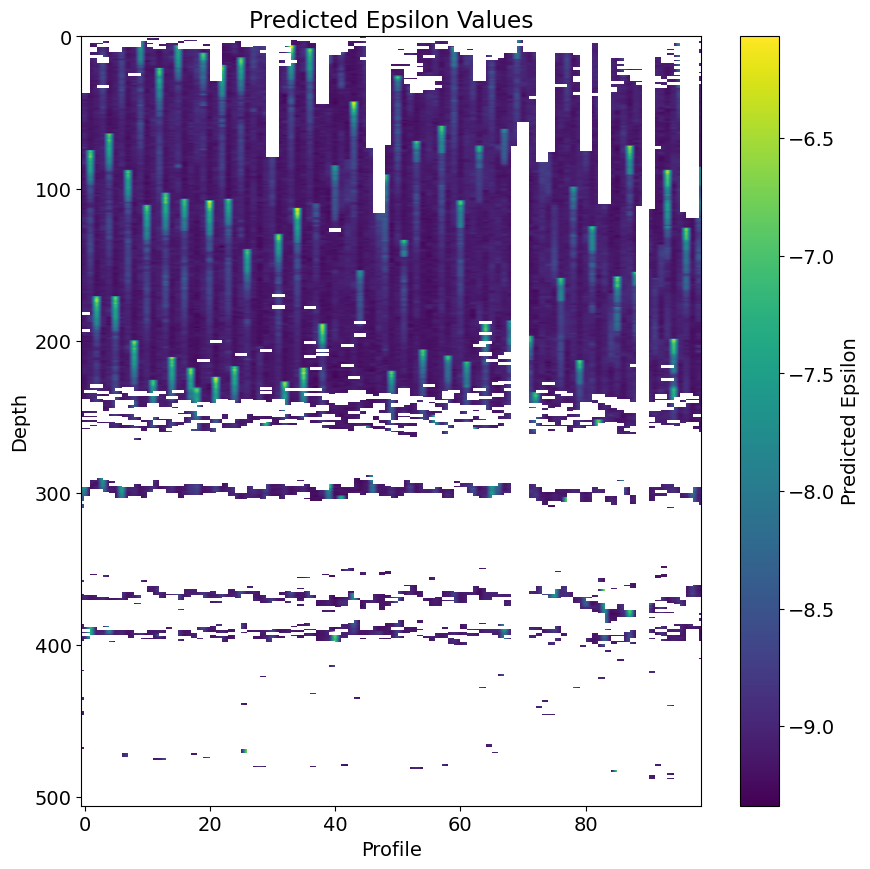

In [17]:
import matplotlib.pyplot as plt

# Transpose the dataframe
transposed_df = merged_df_SIC.pivot('depth', 'profile', 'eps_pred')

# Plot the transposed dataframe as an image or heatmap
plt.imshow(transposed_df, cmap='viridis', aspect='auto')
plt.colorbar(label='Predicted Epsilon')

plt.xlabel('Profile')
plt.ylabel('Depth')
plt.title('Predicted Epsilon Values')

plt.show()

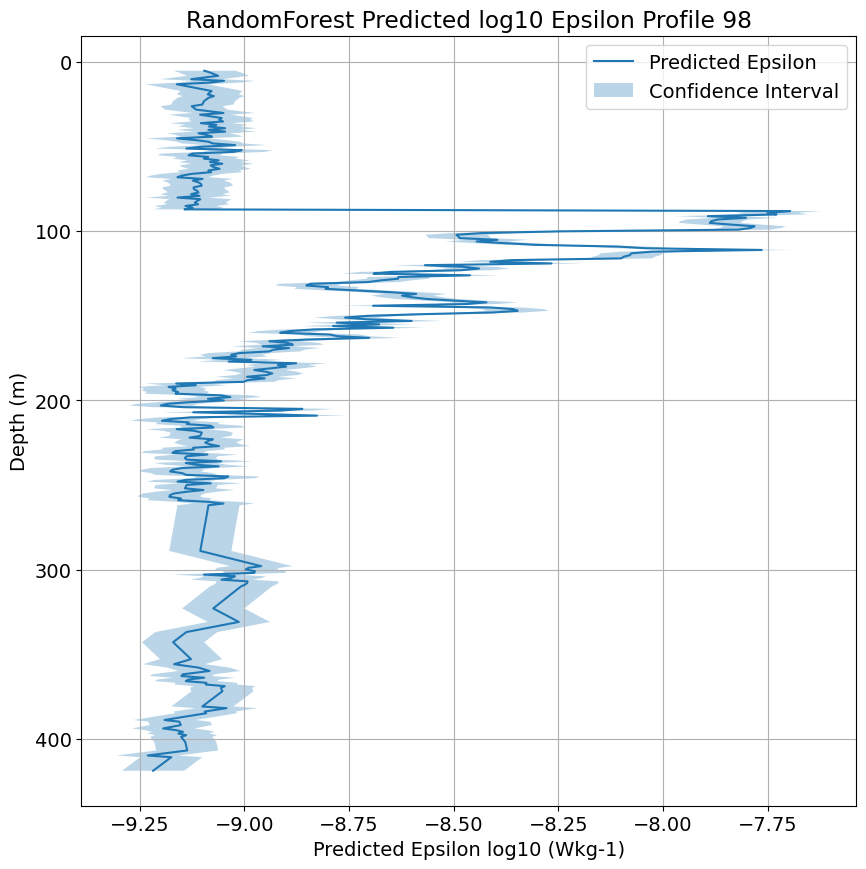

In [45]:
import matplotlib.pyplot as plt

profile_98_df = merged_df_SIC[merged_df_SIC['profile'] == 98]

me = 0.0742  # Mean Error (ME)
ci_lower = profile_98_df['eps_pred'] - me  # Lower bound of the confidence interval
ci_upper = profile_98_df['eps_pred'] + me  # Upper bound of the confidence interval

plt.plot(profile_98_df['eps_pred'], profile_98_df['depth'], label='Predicted Epsilon')
plt.fill_betweenx(profile_98_df['depth'], ci_lower, ci_upper, alpha=0.3, label='Confidence Interval')
plt.xlabel('Predicted Epsilon log10 (Wkg-1)')
plt.ylabel('Depth (m)')
plt.title('RandomForest Predicted log10 Epsilon Profile 98')
plt.grid(True)
plt.legend()

plt.gca().invert_yaxis()  # Invert the y-axis

plt.show()



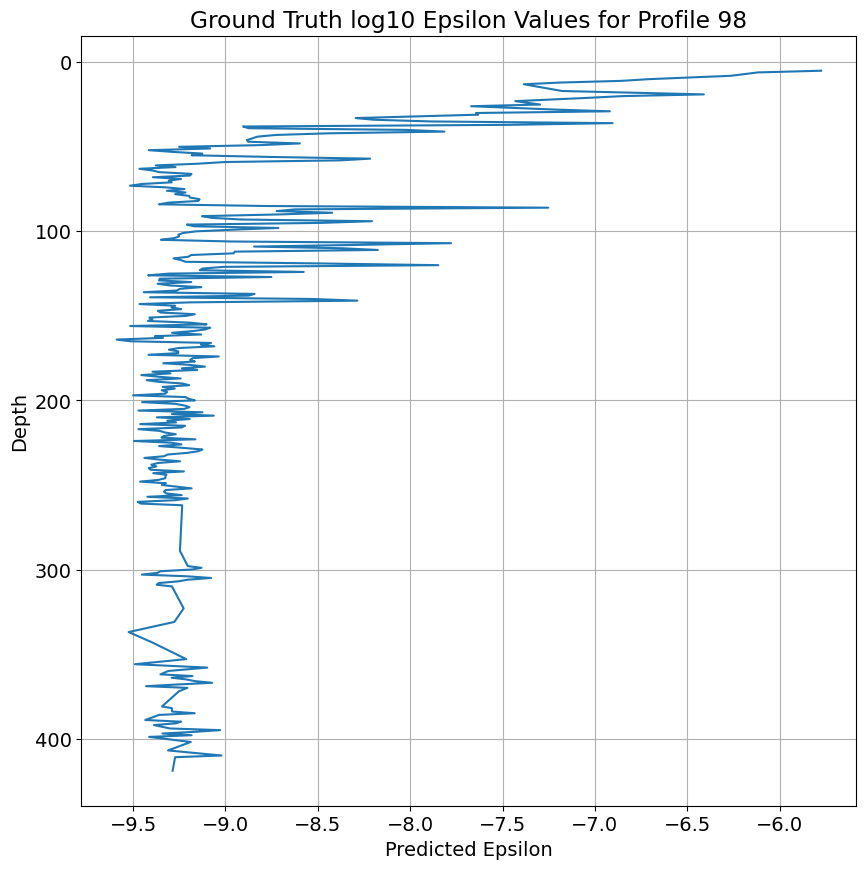

In [43]:
import matplotlib.pyplot as plt

profile_98_df = merged_df_SIC[merged_df_SIC['profile'] == 98]

plt.plot(profile_98_df['log_eps'], profile_98_df['depth'])
plt.xlabel('Predicted Epsilon')
plt.ylabel('Depth')
plt.title('Ground Truth log10 Epsilon Values for Profile 98')
plt.grid(True)

plt.gca().invert_yaxis()  # Invert the y-axis

plt.show()



In [5]:
from sklearn.metrics import r2_score, mean_absolute_error
# Predict the test set labels
y_pred= pipeline.predict(X_test)
r2_score(y_test.values.flatten(), y_pred)

# Calculate the R2 score
r2 = r2_score(y_test.values.flatten(), y_pred)

# Calculate the mean error (ME)
me = np.mean(y_pred - y_test.values.flatten())

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.flatten(), y_pred)

# Calculate the residuals
residuals = y_test.values.flatten() - y_pred

# Calculate the standard deviation of the residuals
residual_std = np.std(residuals)

# Print the metrics
print("R2 Score: {:.4f}".format(r2))
print("Mean Error (ME): {:.4f}".format(me))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))
print("Residual Standard Deviation: {:.4f}".format(residual_std))

R2 Score: -37.8540
Mean Error (ME): 12.3714
Mean Absolute Error (MAE): 12.3714
Residual Standard Deviation: 1.8057


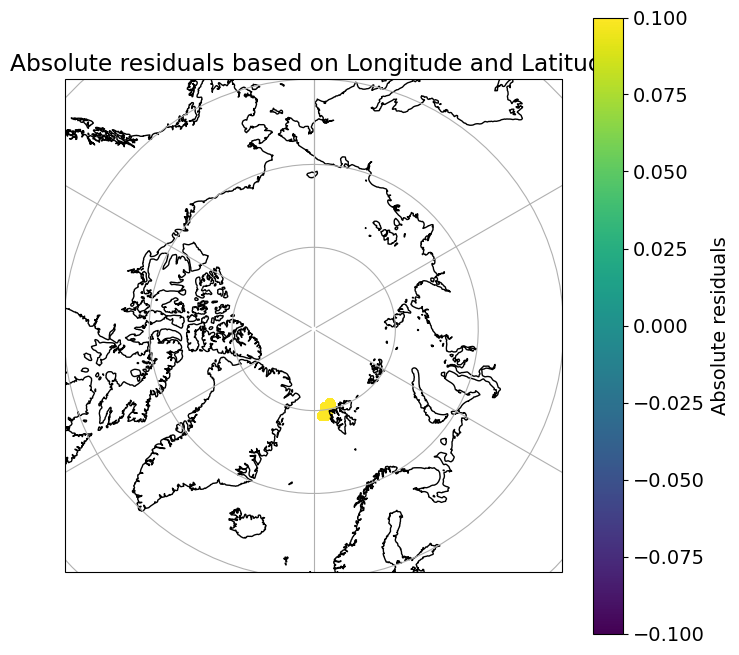

In [7]:
arctic_df = encode_tulabel(arctic_df)
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test, columns=xstringlist_all)
y_test_df_SIC = pd.DataFrame(y_test, columns=ystringlist)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)

merged_df_SIC = SIC_all_testdf.merge(arctic_df, on=xstringlist_all+ystringlist)
merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all+ystringlist)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])
stereo_plot(merged_df_SIC, abs(residuals_SIC), "Absolute residuals")

## Vary ArcticMix

In [58]:
# Features:
# xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['sea_ice_concentration','latitude','depth','hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist = ['log_eps']

pipeline, y_test, X_test, importances, X_train, y_train = RF_regressor(MLD_df, xstringlist_all, ystringlist, "ArcticMix")

-2.5209319121355405
R2 Score: -2.5209, 95% CI: [-2.5860, -2.4590]
Mean Error (ME): 2.5423, 95% CI: [2.5042, 2.5868]
Mean Absolute Error (MAE): 4.4860, 95% CI: [4.4537, 4.5174]
Residual Standard Deviation: 5.7638, 95% CI: [5.7391, 5.7875]


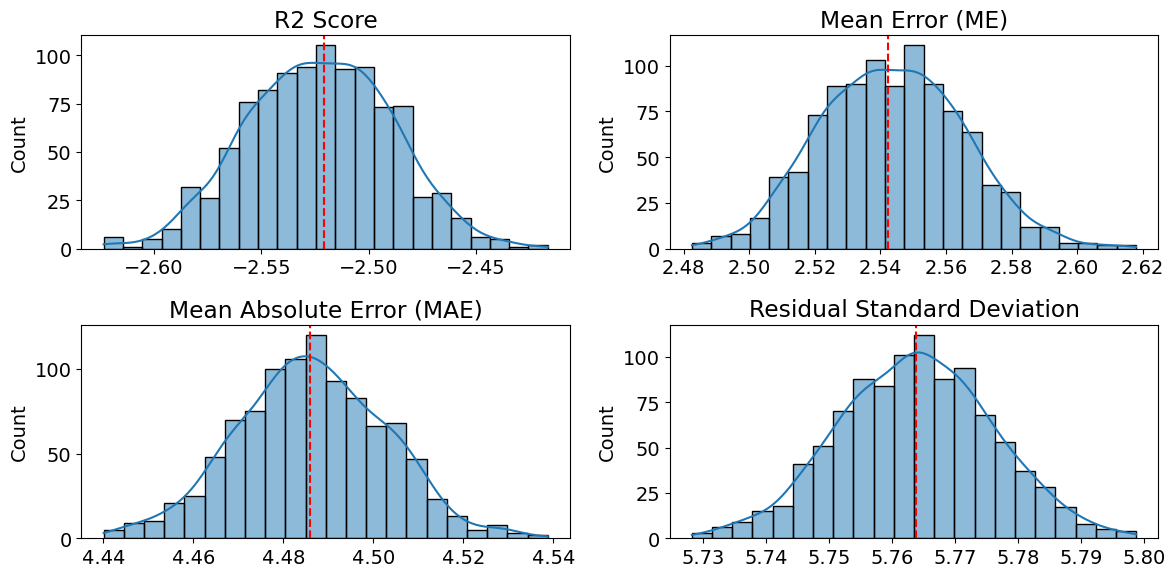

In [60]:
# Predict the test set labels
from src.models.corr_func import confidence_metrics
y_pred= pipeline.predict(X_test)
print(r2_score(y_test, y_pred))

confidence_metrics(y_test, y_pred)

MLD_df, labels = encode_tulabel(MLD_df)
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test, columns=xstringlist_all)
y_test_df_SIC = pd.DataFrame(y_test, columns=ystringlist)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/RandomForest/ArcticMix_testdf.pkl")
# Pickle the DataFrame
SIC_all_testdf .to_pickle(pickle_path)

# TEA_COSI

In [71]:
# Convert 'inf' and '-inf' to 'NaN'
MLD_df = MLD_df.replace([np.inf, -np.inf], np.nan)

# Drop rows with 'NaN' values
MLD_df = MLD_df.dropna()

In [75]:
MLD_df.cruise.unique()

array(['NICE-2015', 'ArcticMix', 'Mosaic', 'Haakon Mosby', 'ABSO',
       'TEA_COSI', 'IPY Barneo 2007', 'IPY Barneo 2008',
       'Nansen Legacy 2018', 'Nansen Legacy 2019', 'ASCOS'], dtype=object)

-9.952653872116711
R2 Score: -9.9527, 95% CI: [-10.5407, -9.4285]
Mean Error (ME): 1.7493, 95% CI: [1.6795, 1.8230]
Mean Absolute Error (MAE): 4.2841, 95% CI: [4.2406, 4.3241]
Residual Standard Deviation: 4.7742, 95% CI: [4.7137, 4.8287]


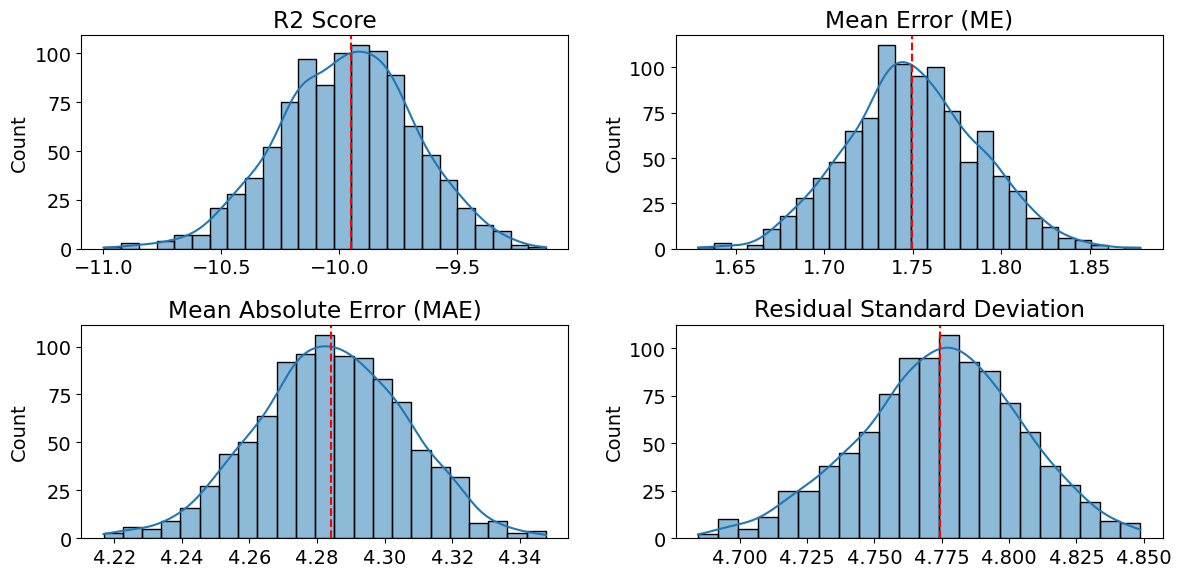

In [76]:
# Features:
# xstringlist = ['S','T','latitude','hab', 'depth','dSdz','dTdz','log_N2', 'Tu_label']
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all = ['sea_ice_concentration','latitude','depth','hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'Tu']

# We want to predict:
ystringlist = ['log_eps']

pipeline, y_test, X_test, importances, X_train, y_train = RF_regressor(MLD_df, xstringlist_all, ystringlist, "TEA_COSI")

# Predict the test set labels

y_pred= pipeline.predict(X_test)
print(r2_score(y_test, y_pred))

confidence_metrics(y_test, y_pred)

MLD_df, labels = encode_tulabel(MLD_df)
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test, columns=xstringlist_all)
y_test_df_SIC = pd.DataFrame(y_test, columns=ystringlist)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

SIC_all_testdf = create_testdf(X_test_df_SIC, y_test_df_SIC, y_pred_df_SIC)

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/RandomForest/TEA_COSI_testdf.pkl")
# Pickle the DataFrame
SIC_all_testdf .to_pickle(pickle_path)